# 학습 환경 설정

## GPU 환경

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2112663208163468488,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2767320659466943958
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6934559456
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1516454175479415948
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9192265618793052425
 physical_device_desc: "device: XLA_GPU device"]

## 사용 데이터 및 모델 버전

In [1]:
f = open("version_log.txt", 'r', encoding='utf-8')
version_info = f.read()
print(version_info)
f.close()

####################################################################################################################
##############################################   Version Infomation   ##############################################
####################################################################################################################

# Data
    ## v1 data
        16개 feature
        시가 고가 저가 종가 volume_btc volume_cur weight_price sma5m sma30m sma60m sma1d sma3d sma7d sma30d sma90d sma180d
        
    ## v2 data
        16개 feature
        시가 고가 저가 종가 volume_btc volume_cur weight_price ema1d ema3d sma7d sma30d sma90d sma180d z-score



# DeepLearning Models
    ## v1 모델
        DNN
            Dense(units=n_hidden1, activation='relu', input_shape=input_size_dnn)
            Dense(units=n_hidden2, activation='relu')
            Dropout(0.4)
            Dense(units=n_hidden3, activation='relu')
            Dropout(0.4)
            Dense(units=n_hidden4, activation='relu')


In [2]:
DATA_VERSION = 3
MODEL_VERSION = 1

# Diretory path
# data path
DATA_PATH = 'data/'
KAGGLE_PATH = 'kaggle/'
# model path
MODEL_PATH = 'models/'
# img path
IMG_PATH = 'img/'

# file path
# data path
BTC_KAGGLE = 'BTC_2012_2021_v{}.csv'.format(DATA_VERSION)
# model path
MODEL_DNN = 'BTC_DNN_v{}.h5'.format(MODEL_VERSION)
MODEL_CNN = 'BTC_CNN_v{}.h5'.format(MODEL_VERSION)
MODEL_RNN = 'BTC_RNN_v{}.h5'.format(MODEL_VERSION)
MODEL_LSTM = 'BTC_LSTM_v{}.h5'.format(MODEL_VERSION)
# image path(for save)
IMG_DNN = "DNN_Dv{}_Mv{}.png".format(DATA_VERSION, MODEL_VERSION)
IMG_CNN = "CNN_Dv{}_Mv{}.png".format(DATA_VERSION, MODEL_VERSION)
IMG_RNN = "RNN_Dv{}_Mv{}.png".format(DATA_VERSION, MODEL_VERSION)
IMG_LSTM = "LSTM_Dv{}_Mv{}.png".format(DATA_VERSION, MODEL_VERSION)

# 데이터 전처리

## 데이터 불러오기

In [3]:
import numpy as np
import pandas as pd

btc_df = pd.read_csv(DATA_PATH + KAGGLE_PATH + BTC_KAGGLE, index_col=0)
btc_df.index = pd.to_datetime(btc_df.index)
btc_df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ema1d,ema3d,sma7d,sma30d,sma90d,sma180d,Z-score
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39,4.39,4.39,5.432311,6.20297,5.473687,5.378391,0.983739
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39,4.39,4.39,5.432311,6.20297,5.473687,5.378391,0.983739
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39,4.39,4.39,5.432311,6.20297,5.473687,5.378391,0.983739
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39,4.39,4.39,5.432311,6.20297,5.473687,5.378391,0.983739
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39,4.39,4.39,5.432311,6.20297,5.473687,5.378391,0.983739


# 학습 가능한 데이터로 변환

## Data Scaling
* 데이터의 값이 너무 크가나 작을 경우 학습과정에서 0으로 수렴하거나 발산할 수 있기 때문에 데이터 스케일링을 진행

1. **최솟값 0이 안되도록 조정**\
    학습 평가시 **MAPE** 지표를 사용할 경우 데이터 값이 분모로 사용된다\
    따라서 분모가 0이 되는 것을 방지하기 위해 데이터의 0을 제거해야한다.
    * 방법 : 각 column의 최솟값에 아주 작은 값을 빼주어 최솟값을 변경해준다

In [4]:
# 각 colum의 최솟값을 저장
min_list = []
for col in btc_df:
    min_list.append(btc_df[col].min())
    
# 각 column의 최솟값보다 0.1작은 값 생성
prevent_zero = np.array(min_list) - 0.1

# 데이터에 마지막 열에 추가 -> 데이터 스케일링 이후 제거
min_row = dict.fromkeys(btc_df.columns)
for i, c in enumerate(min_row.keys()):
    min_row[c] = prevent_zero[i]

import datetime
last_index = pd.to_datetime(btc_df.iloc[[-1]].index) + datetime.timedelta(minutes=1)

min_row_df = pd.DataFrame(min_row, index=last_index)
btc_df = btc_df.append(min_row_df)
btc_df.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ema1d,ema3d,sma7d,sma30d,sma90d,sma180d,Z-score
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,57748.121549,56392.723832,55255.498022,54502.604789,44725.031694,30692.178959,6.634883
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,57748.798661,56393.263317,55255.916752,54502.918730,44725.261949,30692.364550,6.639516
2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,57749.500806,56393.811183,55256.353163,54503.231684,44725.492499,30692.550267,6.643992
2021-03-31 00:00:00,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363,57750.214671,56394.362992,55256.803989,54503.542610,44725.722820,30692.736148,6.646119
2021-03-31 00:01:00,3.70,3.70,3.70,3.70,-0.100000,-0.100000,3.700000,4.290000,4.290000,4.419430,4.758984,4.838784,5.278391,-3.655902


2. Data Scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler
#데이터 스케일링 
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(btc_df)

output = min_max_scaler.transform(btc_df)
output = pd.DataFrame(output, columns=btc_df.columns, index=list(btc_df.index.values))
output

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ema1d,ema3d,sma7d,sma30d,sma90d,sma180d,Z-score
2011-12-31 07:52:00,0.000011,0.000011,0.000011,0.000011,0.000095,1.510718e-07,0.000011,0.000002,0.000002,0.000017,0.000026,0.000014,0.000003,0.313454
2011-12-31 07:53:00,0.000011,0.000011,0.000011,0.000011,0.000112,1.824842e-07,0.000011,0.000002,0.000002,0.000017,0.000026,0.000014,0.000003,0.313454
2011-12-31 07:54:00,0.000011,0.000011,0.000011,0.000011,0.000129,2.138965e-07,0.000011,0.000002,0.000002,0.000017,0.000026,0.000014,0.000003,0.313454
2011-12-31 07:55:00,0.000011,0.000011,0.000011,0.000011,0.000146,2.453089e-07,0.000011,0.000002,0.000002,0.000017,0.000026,0.000014,0.000003,0.313454
2011-12-31 07:56:00,0.000011,0.000011,0.000011,0.000011,0.000163,2.767212e-07,0.000011,0.000002,0.000002,0.000017,0.000026,0.000014,0.000003,0.313454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 23:57:00,0.950136,0.950008,0.951523,0.949885,0.001263,3.080126e-02,0.951015,0.968030,0.975222,0.953249,0.999983,0.999985,0.999982,0.695245
2021-03-30 23:58:00,0.950289,0.950500,0.951676,0.950501,0.000308,7.202326e-03,0.951063,0.968042,0.975231,0.953256,0.999989,0.999990,0.999988,0.695558
2021-03-30 23:59:00,0.951079,0.951254,0.952467,0.951096,0.000140,3.045396e-03,0.952127,0.968054,0.975241,0.953264,0.999994,0.999995,0.999994,0.695860
2021-03-31 00:00:00,0.951493,0.951380,0.952690,0.951381,0.000481,1.146836e-02,0.952168,0.968066,0.975251,0.953272,1.000000,1.000000,1.000000,0.696004


3. 마지막 열 (최솟값 열) 제거

In [6]:
btc_df = btc_df.iloc[:-1]
btc_df.tail()
output = output.iloc[:-1]
output.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ema1d,ema3d,sma7d,sma30d,sma90d,sma180d,Z-score
2021-03-30 23:56:00,0.950627,0.950346,0.951556,0.949888,0.000254,0.005846,0.951007,0.968020,0.975213,0.953242,0.999977,0.999979,0.999976,0.695248
2021-03-30 23:57:00,0.950136,0.950008,0.951523,0.949885,0.001263,0.030801,0.951015,0.968030,0.975222,0.953249,0.999983,0.999985,0.999982,0.695245
2021-03-30 23:58:00,0.950289,0.950500,0.951676,0.950501,0.000308,0.007202,0.951063,0.968042,0.975231,0.953256,0.999989,0.999990,0.999988,0.695558
2021-03-30 23:59:00,0.951079,0.951254,0.952467,0.951096,0.000140,0.003045,0.952127,0.968054,0.975241,0.953264,0.999994,0.999995,0.999994,0.695860
2021-03-31 00:00:00,0.951493,0.951380,0.952690,0.951381,0.000481,0.011468,0.952168,0.968066,0.975251,0.953272,1.000000,1.000000,1.000000,0.696004


## DNN 학습을 위한 데이터

In [14]:
data = np.array(output)
data

array([[1.11723051e-05, 1.11690011e-05, 1.11886116e-05, ...,
        1.41970212e-05, 3.25866029e-06, 3.13453790e-01],
       [1.11723051e-05, 1.11690011e-05, 1.11886116e-05, ...,
        1.41970212e-05, 3.25866029e-06, 3.13453790e-01],
       [1.11723051e-05, 1.11690011e-05, 1.11886116e-05, ...,
        1.41970212e-05, 3.25866029e-06, 3.13453790e-01],
       ...,
       [9.50289233e-01, 9.50500444e-01, 9.51676224e-01, ...,
        9.99989694e-01, 9.99987891e-01, 6.95557653e-01],
       [9.51078581e-01, 9.51253785e-01, 9.52466724e-01, ...,
        9.99994850e-01, 9.99993943e-01, 6.95860068e-01],
       [9.51492604e-01, 9.51380043e-01, 9.52690334e-01, ...,
        1.00000000e+00, 1.00000000e+00, 6.96003727e-01]])

In [15]:
X_dnn, y_dnn = data[:-1], data[1:, 3]

# train/validation/test size 설정
train_size = int(len(X_dnn)*0.6)
validation_size = int(len(X_dnn)*0.3)+train_size

# train/test 학습 및 라벨 설정
X_train_dnn = X_dnn[:train_size]
y_train_dnn = y_dnn[:train_size]
X_val_dnn = X_dnn[train_size:validation_size]
y_val_dnn = y_dnn[train_size:validation_size]
X_test_dnn = X_dnn[validation_size:]
y_test_dnn = y_dnn[validation_size:]

print("train\t\tvalidation\ttest")
print("{}\t\t{}\t\t{}".format(len(X_train_dnn), len(X_val_dnn), len(X_test_dnn)))
print("================================================================")
print("Shape of Train set : \t  ", (X_train_dnn.shape, y_train_dnn.shape))
print("Shape of Validation set : ", (X_val_dnn.shape, y_val_dnn.shape))
print("Shape of Test set : \t  ", (X_test_dnn.shape, y_test_dnn.shape))

train		validation	test
2918308		1459154		486386
Shape of Train set : 	   ((2918308, 14), (2918308,))
Shape of Validation set :  ((1459154, 14), (1459154,))
Shape of Test set : 	   ((486386, 14), (486386,))


## 시계열 데이터셋 구성

* window 만큼의 시계열 데이터로 window + 1번째 데이터를 예측하기 위한 데이터 셋 구성

In [7]:
window = 30

In [8]:
data = np.array(output)
data

array([[1.11723051e-05, 1.11690011e-05, 1.11886116e-05, ...,
        1.41970212e-05, 3.25866029e-06, 3.13453790e-01],
       [1.11723051e-05, 1.11690011e-05, 1.11886116e-05, ...,
        1.41970212e-05, 3.25866029e-06, 3.13453790e-01],
       [1.11723051e-05, 1.11690011e-05, 1.11886116e-05, ...,
        1.41970212e-05, 3.25866029e-06, 3.13453790e-01],
       ...,
       [9.50289233e-01, 9.50500444e-01, 9.51676224e-01, ...,
        9.99989694e-01, 9.99987891e-01, 6.95557653e-01],
       [9.51078581e-01, 9.51253785e-01, 9.52466724e-01, ...,
        9.99994850e-01, 9.99993943e-01, 6.95860068e-01],
       [9.51492604e-01, 9.51380043e-01, 9.52690334e-01, ...,
        1.00000000e+00, 1.00000000e+00, 6.96003727e-01]])

In [9]:
# 시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq, window):
    X=[]; Y=[]
    for i in range(len(seq) - window):
        x = seq[i: i + window]
        y = seq[i + window]
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [10]:
X, y = seq2dataset(data, window)

X.shape, y.shape

((4863819, 30, 14), (4863819, 14))

In [11]:
# train/validation/test size 설정
train_size = int(len(X)*0.6)
validation_size = int(len(X)*0.3)+train_size

# train/test 학습 및 라벨 설정
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:validation_size]
y_val = y[train_size:validation_size]
X_test = X[validation_size:]
y_test = y[validation_size:]

print("train\t\tvalidation\ttest")
print("{}\t\t{}\t\t{}".format(len(X_train), len(X_val), len(X_test)))
print("================================================================")
print("Shape of Train set : \t  ", (X_train.shape, y_train.shape))
print("Shape of Validation set : ", (X_val.shape, y_val.shape))
print("Shape of Test set : \t  ", (X_test.shape, y_test.shape))

train		validation	test
2918291		1459145		486383
Shape of Train set : 	   ((2918291, 30, 14), (2918291, 14))
Shape of Validation set :  ((1459145, 30, 14), (1459145, 14))
Shape of Test set : 	   ((486383, 30, 14), (486383, 14))


### Close(종가) 1개만 예측하기 위한 데이터

In [12]:
# 결과 값을 종가 예측으로
y_train = y_train[:, 3]
print(y_train.shape)
# y_train = y_train.reshape(y_train.shape[0], predict_seq, 1)
y_val = y_val[:, 3]
# y_val = y_val.reshape(y_val.shape[0], predict_seq, 1)
y_test = y_test[:, 3]
# y_test = y_test.reshape(y_test.shape[0], predict_seq, 1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2918291,)
(2918291, 30, 14) (2918291,)
(1459145, 30, 14) (1459145,)
(486383, 30, 14) (486383,)


* 저장 (필요시 진행)

In [19]:
# np.save('data/X_train.npy', X_train)
# np.save('data/y_train.npy', y_train)
# np.save('data/X_val.npy', X_val)
# np.save('data/y_val.npy', y_val)
# np.save('data/X_test.npy', X_test)
# np.save('data/y_test.npy', y_test)

### Open(시가) High(고가) Low(저가) Close(종가) 4개 예측하기 위한 데이터

In [ ]:
# 결과 값을 종가 예측으로
y_train = y_train[:, 0:4]
print(y_train.shape)
# y_train = y_train.reshape(y_train.shape[0], predict_seq, 1)
y_val = y_val[:, 0:4]
# y_val = y_val.reshape(y_val.shape[0], predict_seq, 1)
y_test = y_test[:, 0:4]
# y_test = y_test.reshape(y_test.shape[0], predict_seq, 1)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

# DeepLearning Modeling

## 데이터 및 필요한 library import

In [17]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, SimpleRNN, LSTM, Dropout, AveragePooling1D, Flatten, MaxPooling1D
from tensorflow.keras.losses import MeanAbsolutePercentageError
import matplotlib.pyplot as plt

* 기존의 데이터가 있을 경우

In [2]:
# import numpy as np
# X_train = np.load('data/X_train.npy')
# y_train = np.load('data/y_train.npy')
# X_val = np.load('data/X_val.npy')
# y_val = np.load('data/y_val.npy')
# X_test = np.load('data/X_test.npy')
# y_test = np.load('data/y_test.npy')

## Custom MASE Loss and Metrics 구현 - 미완성

In [3]:
def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

def mase(y_true, y_pred):
    sust = tf.reduce_mean(tf.abs(y_true[:,1:] - y_true[:,:-1]))
    diff = tf.reduce_mean(tf.abs(y_pred - y_true))

    return diff/sust

def custom_mase(y_true, y_pred):
    score = tf.py_function(func=mase, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mase') # tf 2.x
    return score

# model.compile(optimizer='adam', loss='mse', metrics=[mase])

In [ ]:
class MASE_metrics(keras.metrics.Metric):
    def __init__(self, name="mase", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


In [9]:
from tensorflow.keras.losses import Loss

class MASE(Loss): #inherit parent class
    #class attribute
    seasonality = 1
  
    #initialize instance attributes
    def __init__(self, seasonality):
        super().__init__()
        self.seasonality = seasonality

    def _naive_forecasting(self, actual, seasonality: int = 1):
        return actual[:-seasonality]
    
    def _error(self, actual, predicted):
        return actual - predicted
    
    def _mae(self, actual, predicted):
        return tf.reduce_mean(tf.abs(self._error(actual, predicted)))

    #compute loss
    def call(self, y_true, y_pred):
        return self._mae(y_true, y_pred) / self._mae(y_true[self.seasonality:], self._naive_forecasting(y_true, self.seasonality))

## DNN 모델

### 학습 파라미터 설정

In [16]:
learning_rate = 0.01
epoch = 15
batch_size = 200
input_size_dnn = X_train_dnn[0].shape
n_hidden1 = 1024
n_hidden2 = 512
n_hidden3 = 256
n_hidden4 = 128
n_output = 1

print("Learning Rate : ", learning_rate)
print("Epoch : ", epoch)
print("Batch Size : ", batch_size)
print("Input Size : ", input_size_dnn)

Learning Rate :  0.01
Epoch :  15
Batch Size :  200
Input Size :  (14,)


### 모델 구현

In [17]:
# 모델구조
model_dnn = Sequential()
model_dnn.add(Dense(units=n_hidden1, activation='relu', input_shape=input_size_dnn))
model_dnn.add(Dense(units=n_hidden2, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(units=n_hidden3, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(units=n_hidden4, activation='relu'))
model_dnn.add(Dense(units=n_output))

# Dropout?

# 오차함수 및 최적화함수 설정
model_dnn.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
model_dnn.summary()

# 학습
history = model_dnn.fit(X_train_dnn, y_train_dnn, epochs=epoch, batch_size=batch_size, validation_data=(X_val_dnn, y_val_dnn), verbose=1)

# 모델 평가
dnn_val_mse, dnn_val_mae, dnn_val_mape = model_dnn.evaluate(X_test_dnn, y_test_dnn, verbose=0)
dnn_val_mse, dnn_val_mae, dnn_val_mape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              15360     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1

(0.1088598370552063, 0.25189441442489624, 68.7190933227539)

#### 모델 저장 및 불러오기

In [18]:
model_dnn.save('models/BTC_DNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))

In [14]:
import tensorflow as tf
model_dnn = tf.keras.models.load_model('models/BTC_DNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))
model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              18432     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

### 결과 시각화

#### 학습이 잘 이루어졌는지 예측

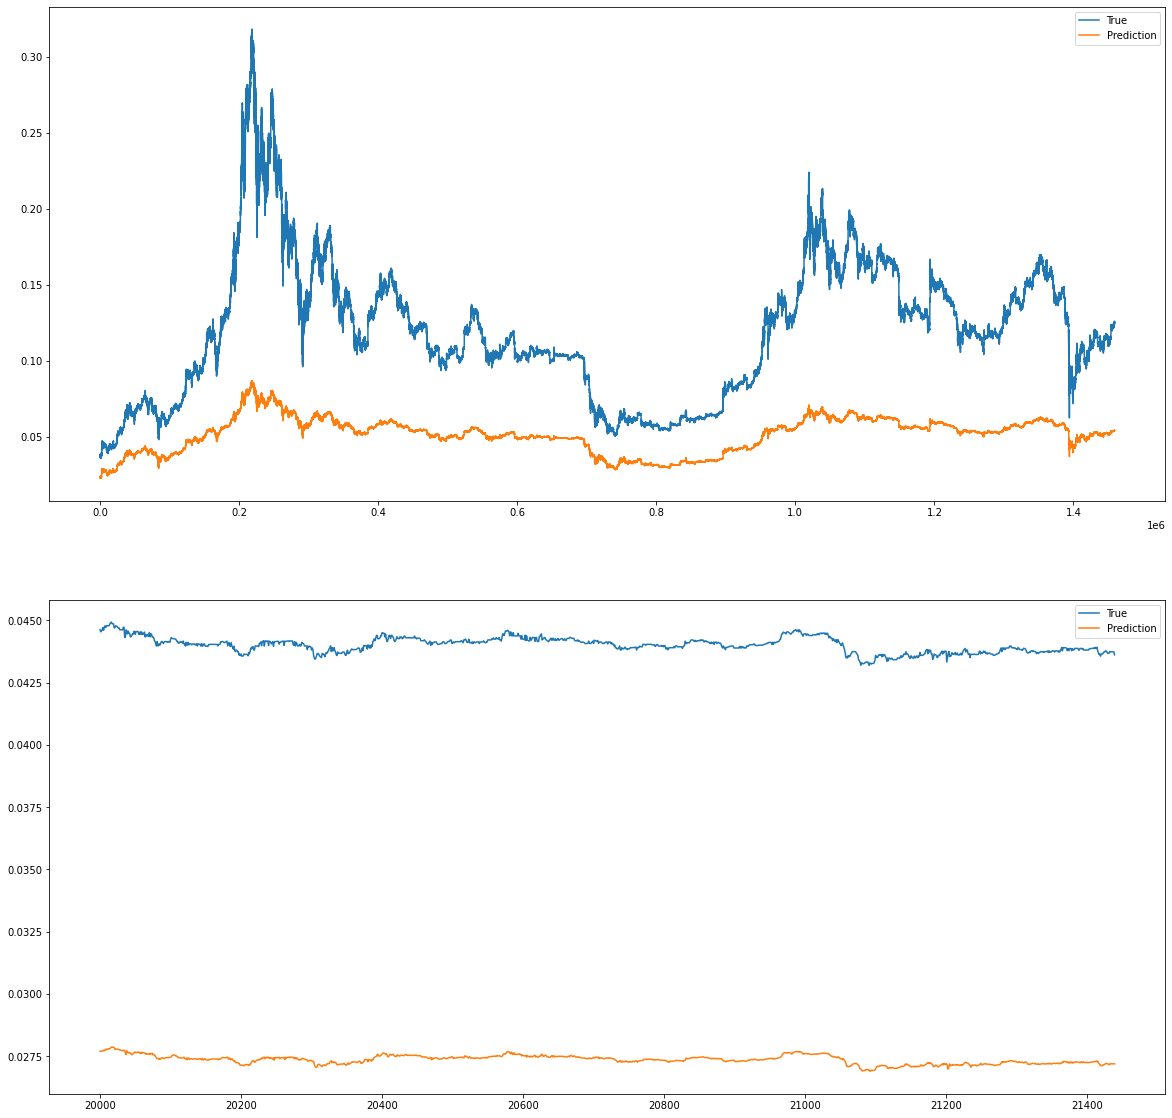

In [19]:
#학습이 잘 이루어졌는지 예측
pred_val = model_dnn.predict(X_val_dnn)
x_range = range(20000, 21440) # 24시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(211)
ax1.plot(y_val_dnn, label='True')
ax1.plot(pred_val, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(x_range, y_val_dnn[x_range], label='True')
ax2.plot(x_range, pred_val[x_range], label='Prediction')
ax2.legend()

plt.savefig('img/DNN_train_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

#### 예측 결과 시각화

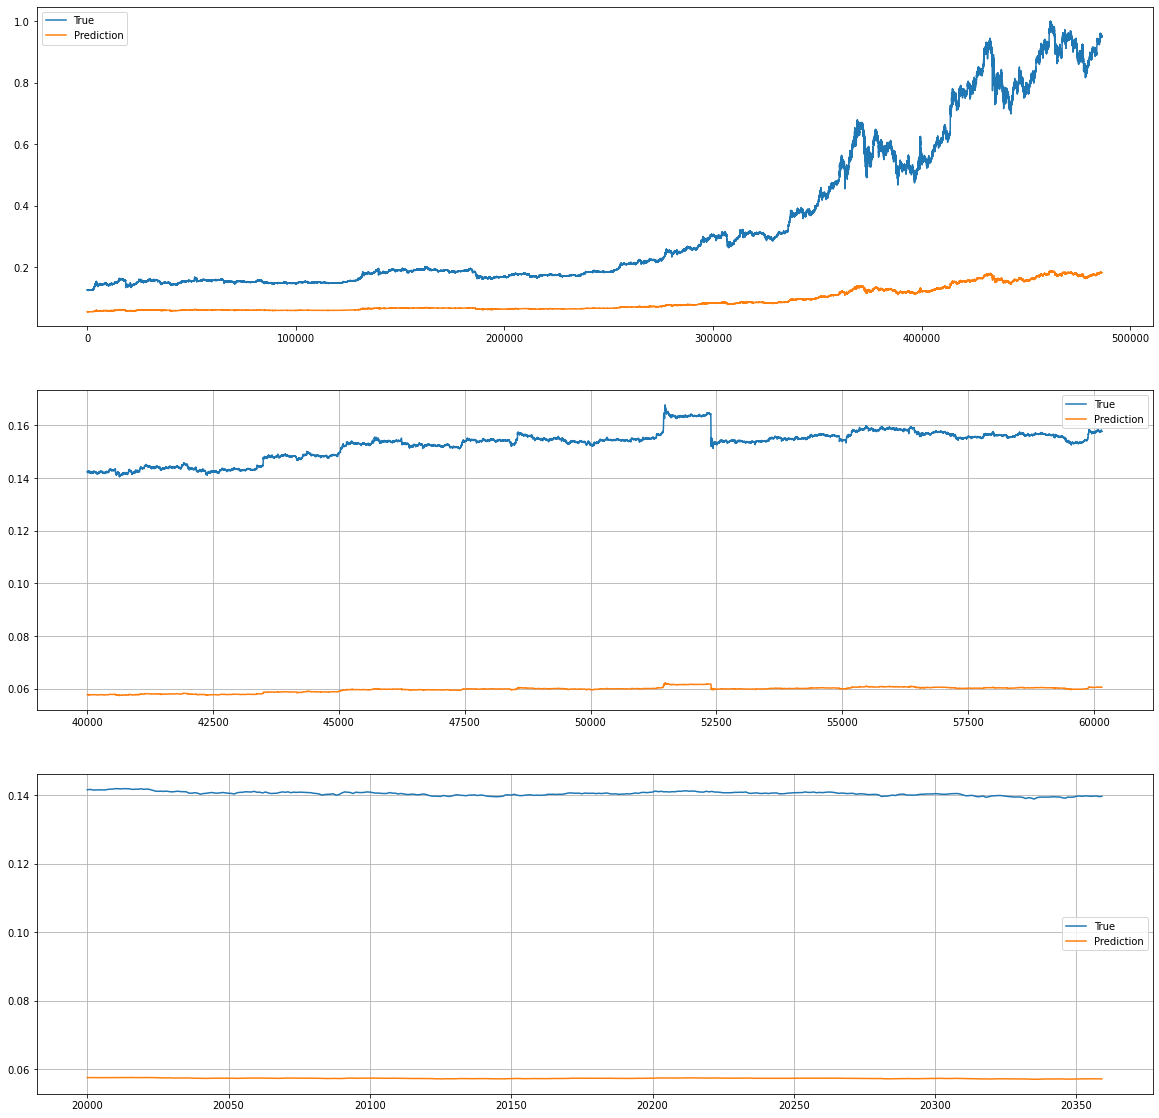

In [20]:
# test case로 예측
pred = model_dnn.predict(X_test_dnn)

x_range1 = range(40000, 60160)  # 2주일
x_range2 = range(20000, 20360)  # 6시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(311)
ax1.plot(y_test_dnn, label='True')
ax1.plot(pred, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.plot(x_range1, y_test_dnn[x_range1], label='True')
ax2.plot(x_range1, pred[x_range1], label='Prediction')
ax2.legend()
ax2.grid()

ax3 = fig.add_subplot(313)
ax3.plot(x_range2, y_test_dnn[x_range2], label='True')
ax3.plot(x_range2, pred[x_range2], label='Prediction')
ax3.legend()
ax3.grid()

plt.savefig('img/DNN_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

## CNN 모델

### 학습 파라미터 설정

In [14]:
learning_rate = 0.01
epoch = 15
batch_size = 200
input_size = X_train[0].shape
print("Learning Rate : ", learning_rate)
print("Epoch : ", epoch)
print("Batch Size : ", batch_size)
print("Input Size : ", input_size)

Learning Rate :  0.01
Epoch :  15
Batch Size :  200
Input Size :  (30, 14)


### 모델 구현

In [17]:
# 모델구조
model_cnn = Sequential()
model_cnn.add(Conv1D(128, 3, activation='relu',input_shape=input_size))
model_cnn.add(Conv1D(64, 3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.4))
model_cnn.add(Dense(1))

# 오차함수 및 최적화함수 설정
model_cnn.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
model_cnn.summary()

# 학습
history = model_cnn.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

# 모델 평가
cnn_val_mse, cnn_val_mae, cnn_val_mape = model_cnn.evaluate(X_test, y_test, verbose=0)
cnn_val_mse, cnn_val_mae, cnn_val_mape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 128)           5504      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                53312     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

(0.0001599799288669601, 0.007760995998978615, 1.6096320152282715)

#### 모델 저장 및 불러오기

In [18]:
model_cnn.save('models/BTC_CNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))

In [24]:
import tensorflow as tf
model_cnn = tf.keras.models.load_model('models/BTC_CNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 128)           6656      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                53312     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [27]:
cnn_val_mse, cnn_val_mae, cnn_val_mape

(0.003368052653968334, 0.03792821988463402, 8.138006210327148)

### 결과 시각화

#### 학습이 잘 이루어졌는지 예측

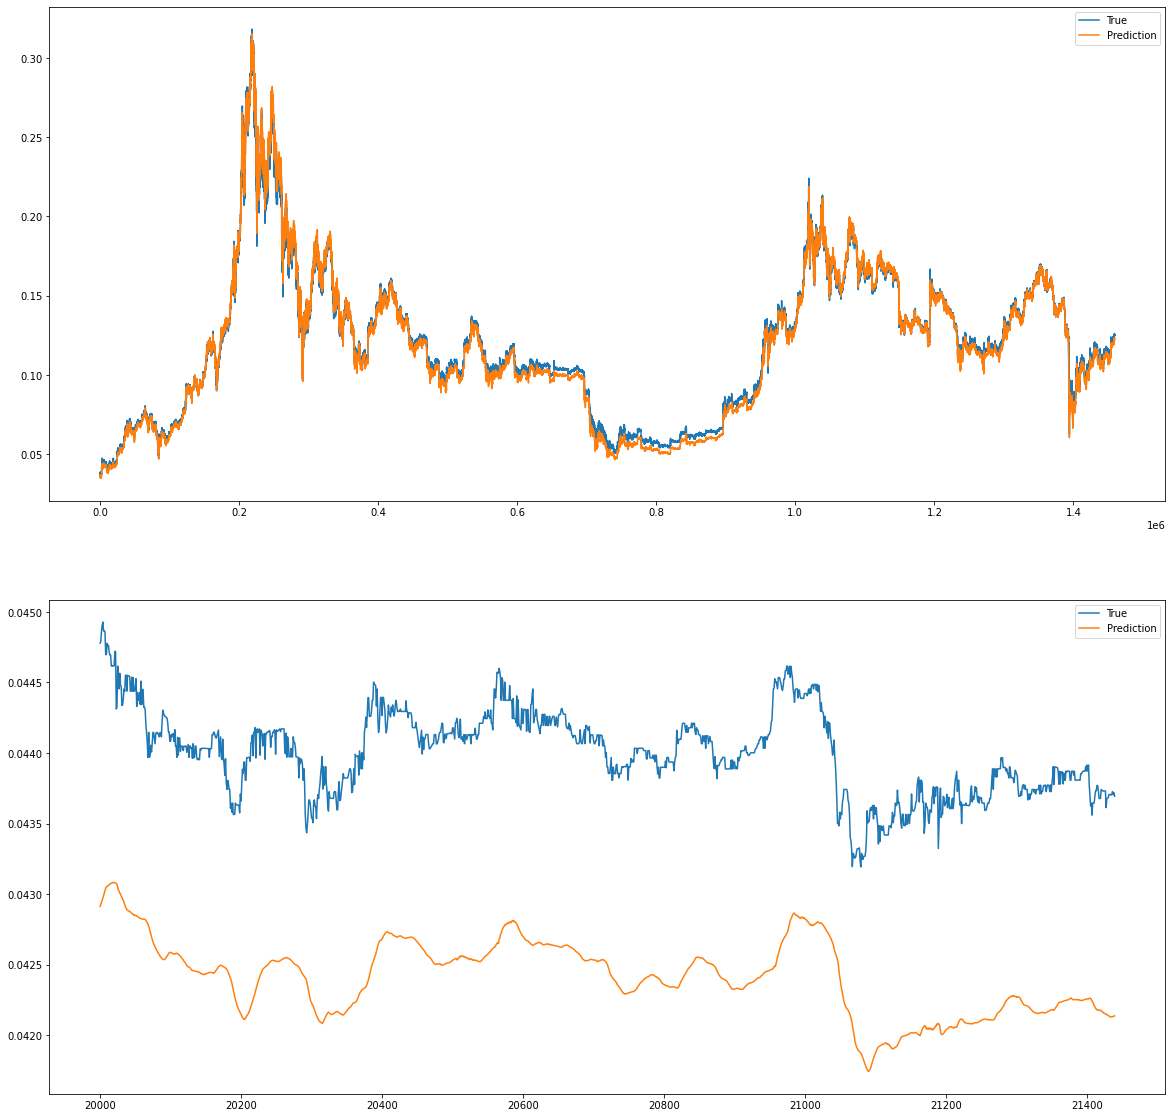

In [19]:
#학습이 잘 이루어졌는지 예측
pred_val = model_cnn.predict(X_val)
x_range = range(20000, 21440) # 24시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(211)
ax1.plot(y_val, label='True')
ax1.plot(pred_val, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(x_range, y_val[x_range], label='True')
ax2.plot(x_range, pred_val[x_range], label='Prediction')
ax2.legend()

plt.savefig('img/CNN_train_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

#### 예측 결과 시각화

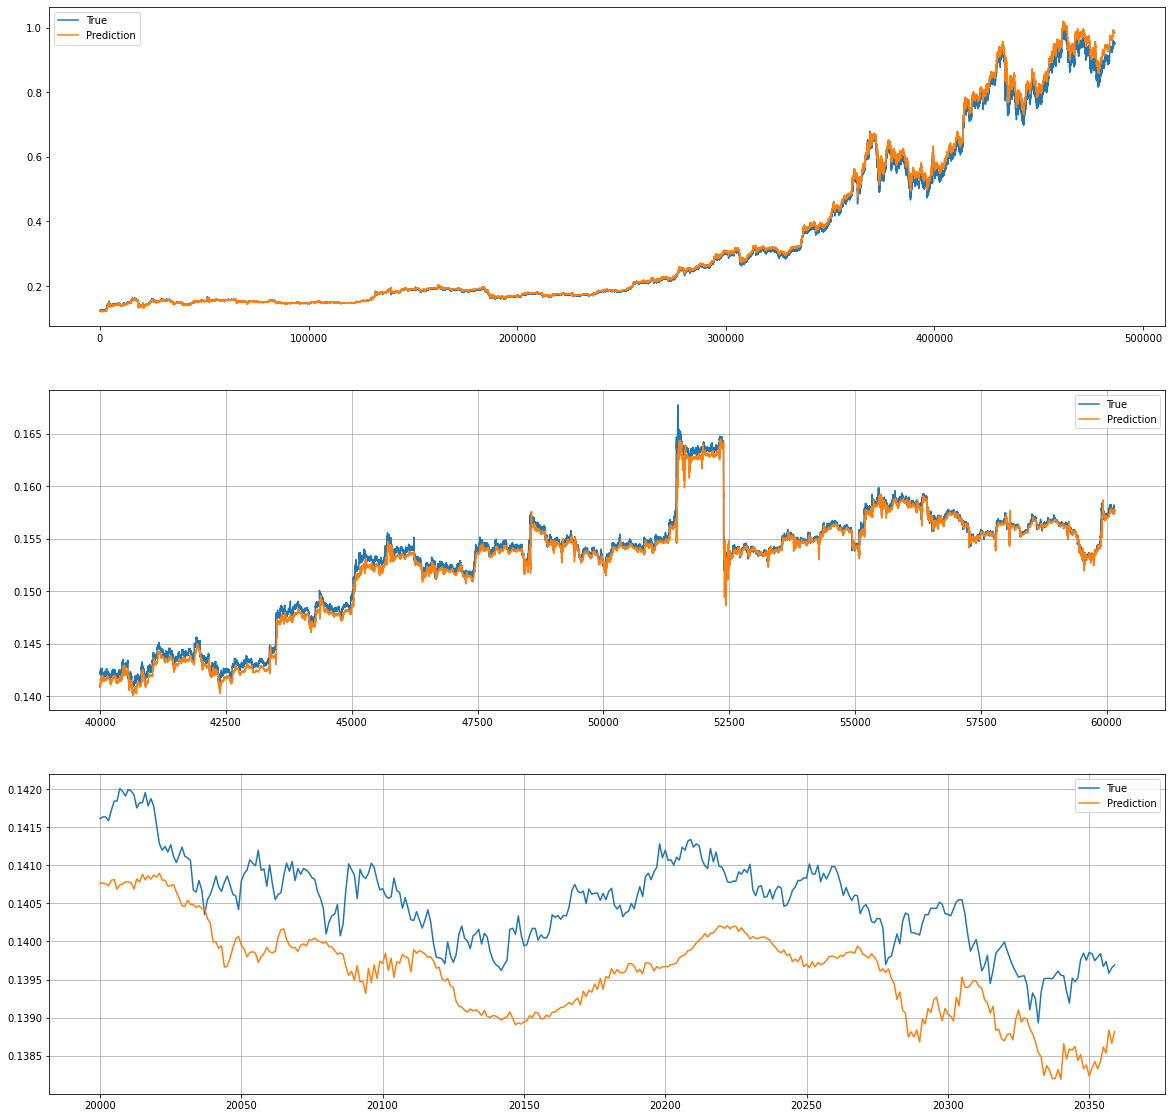

In [20]:
# test case로 예측
pred = model_cnn.predict(X_test)

x_range1 = range(40000, 60160)  # 2주일
x_range2 = range(20000, 20360)  # 6시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(311)
ax1.plot(y_test, label='True')
ax1.plot(pred, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.plot(x_range1, y_test[x_range1], label='True')
ax2.plot(x_range1, pred[x_range1], label='Prediction')
ax2.legend()
ax2.grid()

ax3 = fig.add_subplot(313)
ax3.plot(x_range2, y_test[x_range2], label='True')
ax3.plot(x_range2, pred[x_range2], label='Prediction')
ax3.legend()
ax3.grid()

plt.savefig('img/CNN_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

## RNN 모델

### 학습 파라미터 설정

In [24]:
learning_rate = 0.01
epoch = 8
batch_size = 200
input_size = X_train[0].shape
print("Learning Rate : ", learning_rate)
print("Epoch : ", epoch)
print("Batch Size : ", batch_size)
print("Input Size : ", input_size)

Learning Rate :  0.01
Epoch :  8
Batch Size :  200
Input Size :  (30, 14)


### 모델 구현

In [25]:
# 모델구조
model_rnn = Sequential()
model_rnn.add(SimpleRNN(512, activation='relu', input_shape=input_size)) # 512는 다른숫자로도 사용가능
model_rnn.add(Dense(1)) # output(target)은 '종가'이기 때문에 1요소 = Dense의 output레이어는 1로 설정

# 오차함수 및 최적화함수 설정
model_rnn.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
model_rnn.summary()

# 학습
history = model_rnn.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

# 모델 평가
rnn_val_mse, rnn_val_mae, rnn_val_mape = model_rnn.evaluate(X_test, y_test, verbose=0)
rnn_val_mse, rnn_val_mae, rnn_val_mape

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 512)               269824    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 270,337
Trainable params: 270,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
14592/14592 [==============================] - 233s 16ms/step - loss: 1.8668e-06 - mae: 2.0398e-04 - mape: 76.4021 - val_loss: 4.5795e-04 - val_mae: 0.0191 - val_mape: 15.2460
Epoch 2/8
14592/14592 [==============================] - 226s 15ms/step - loss: 1.3118e-08 - mae: 7.9961e-05 - mape: 30.7297 - val_loss: 6.5827e-04 - val_mae: 0.0233 - val_mape: 19.0061
Epoch 3/8
14592/14592 [==============================] - 219s 15ms/step - loss: 6.9692e-09 - mae: 6.1914e-05 - mape: 23.6956 - val_loss: 3

(0.0008554876549169421, 0.01987026259303093, 4.598385334014893)

#### 모델 저장 및 불러오기

In [26]:
model_rnn.save('models/BTC_RNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))

In [18]:
import tensorflow as tf
model_rnn = tf.keras.models.load_model('models/BTC_RNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 512)               271360    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 271,873
Trainable params: 271,873
Non-trainable params: 0
_________________________________________________________________


* MAPE(평균 절댓값 백분율 오차)를 보면 매우 큰 값을 가지는 것을 확인 할 수 있다.\
    -> 절대 오차를 실제 데이터로 나누기 때문에 0에 가까운 값이 있으면 MAPE가 상당히 크게 팽창할 수 있다. 따라서 대안 찾아보기

### 결과 시각화

#### 학습이 잘 이루어졌는지 예측

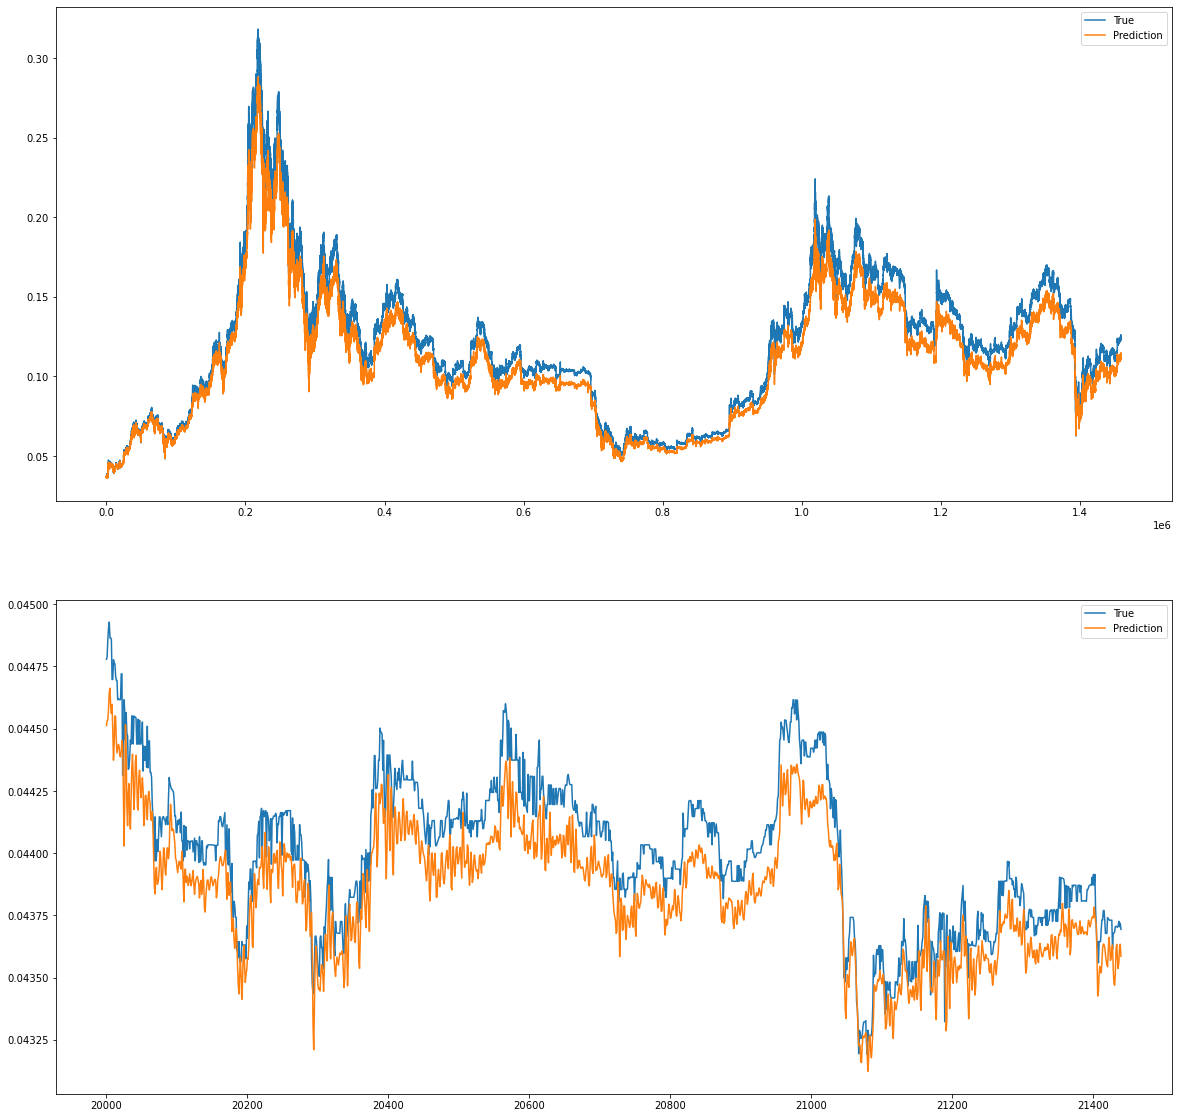

In [21]:
#학습이 잘 이루어졌는지 예측
pred_val = model_rnn.predict(X_val)
x_range = range(20000, 21440) # 24시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(211)
ax1.plot(y_val, label='True')
ax1.plot(pred_val, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(x_range, y_val[x_range], label='True')
ax2.plot(x_range, pred_val[x_range], label='Prediction')
ax2.legend()

plt.savefig('img/RNN_train_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

#### 예측 결과 시각화

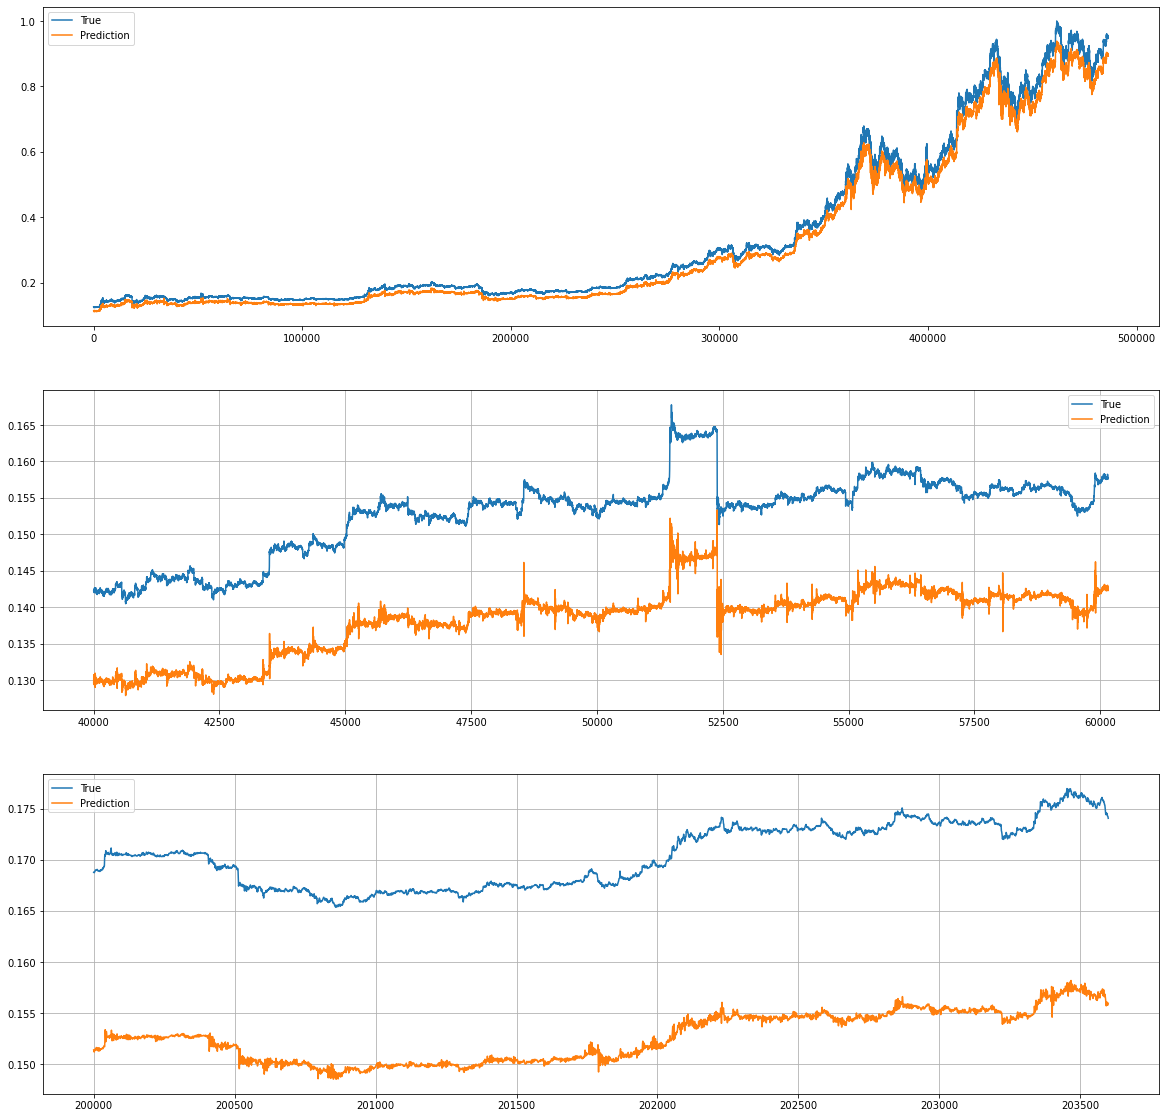

In [22]:
# test case로 예측
pred = model_rnn.predict(X_test)

x_range1 = range(40000, 60160)  # 2주일
x_range2 = range(200000, 203600)  # 6시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(311)
ax1.plot(y_test, label='True')
ax1.plot(pred, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.plot(x_range1, y_test[x_range1], label='True')
ax2.plot(x_range1, pred[x_range1], label='Prediction')
ax2.legend()
ax2.grid()

ax3 = fig.add_subplot(313)
ax3.plot(x_range2, y_test[x_range2], label='True')
ax3.plot(x_range2, pred[x_range2], label='Prediction')
ax3.legend()
ax3.grid()

plt.savefig('img/RNN_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

## LSTM 모델

### 학습 파라미터 설정

In [14]:
learning_rate = 0.01
epoch = 8
batch_size = 200
input_size = X_train[0].shape

print("Learning Rate : ", learning_rate)
print("Epoch : ", epoch)
print("Batch Size : ", batch_size)
print("Input Size : ", input_size)

Learning Rate :  0.01
Epoch :  8
Batch Size :  200
Input Size :  (30, 14)


### 모델 구현

In [15]:
# 모델구조
model_lstm = Sequential()
model_lstm.add(LSTM(512, activation='relu', input_shape=input_size)) # 512는 다른숫자로도 사용가능
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1)) # output(target)은 '종가'이기 때문에 1요소 = Dense의 output레이어는 1로 설정


# 오차함수 및 최적화함수 설정
model_lstm.compile(loss='mse', optimizer='adam', metrics=['mae','mape'])
model_lstm.summary()

# 학습
history = model_lstm.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1)

# 모델 평가
lstm_val_mse, lstm_val_mae, lstm_val_mape = model_lstm.evaluate(X_test, y_test, verbose=0)
lstm_val_mse, lstm_val_mae, lstm_val_mape

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1079296   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,079,809
Trainable params: 1,079,809
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
14592/14592 [==============================] - 613s 42ms/step - loss: 7.0214e-07 - mae: 3.9006e-04 - mape: 188.8291 - val_loss: 4.7972e-05 - val_mae: 0.0051 - val_mape: 3.7961
Epoch 2/8
14592/14592 [==============================] - 595s 41ms/step - loss: 2.4306e-07 - mae: 3.1184e-04 - mape: 167.6373 - val_loss: 6.6782e-05 - val_mae: 0.0062 - val_mape: 4.6867
Epoc

(0.00048405848792754114, 0.011915717273950577, 1.9215487241744995)

* MAPE(평균 절댓값 백분율 오차)를 보면 매우 큰 값을 가지는 것을 확인 할 수 있다.\
    -> 절대 오차를 실제 데이터로 나누기 때문에 0에 가까운 값이 있으면 MAPE가 상당히 크게 팽창할 수 있다. 따라서 대안 찾아보기

#### 모델 저장 및 불러오기

In [16]:
model_lstm.save('models/BTC_LSTM_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))

In [21]:
import tensorflow as tf
model_lstm = tf.keras.models.load_model('models/BTC_LSTM_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION))
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1085440   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,085,953
Trainable params: 1,085,953
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_val_mse, lstm_val_mae, lstm_val_mape = model_lstm.evaluate(X_test, y_test, verbose=0)

lstm_val_mse, lstm_val_mae, lstm_val_mape

### 결과 시각화

#### 학습이 잘 이루어졌는지 예측

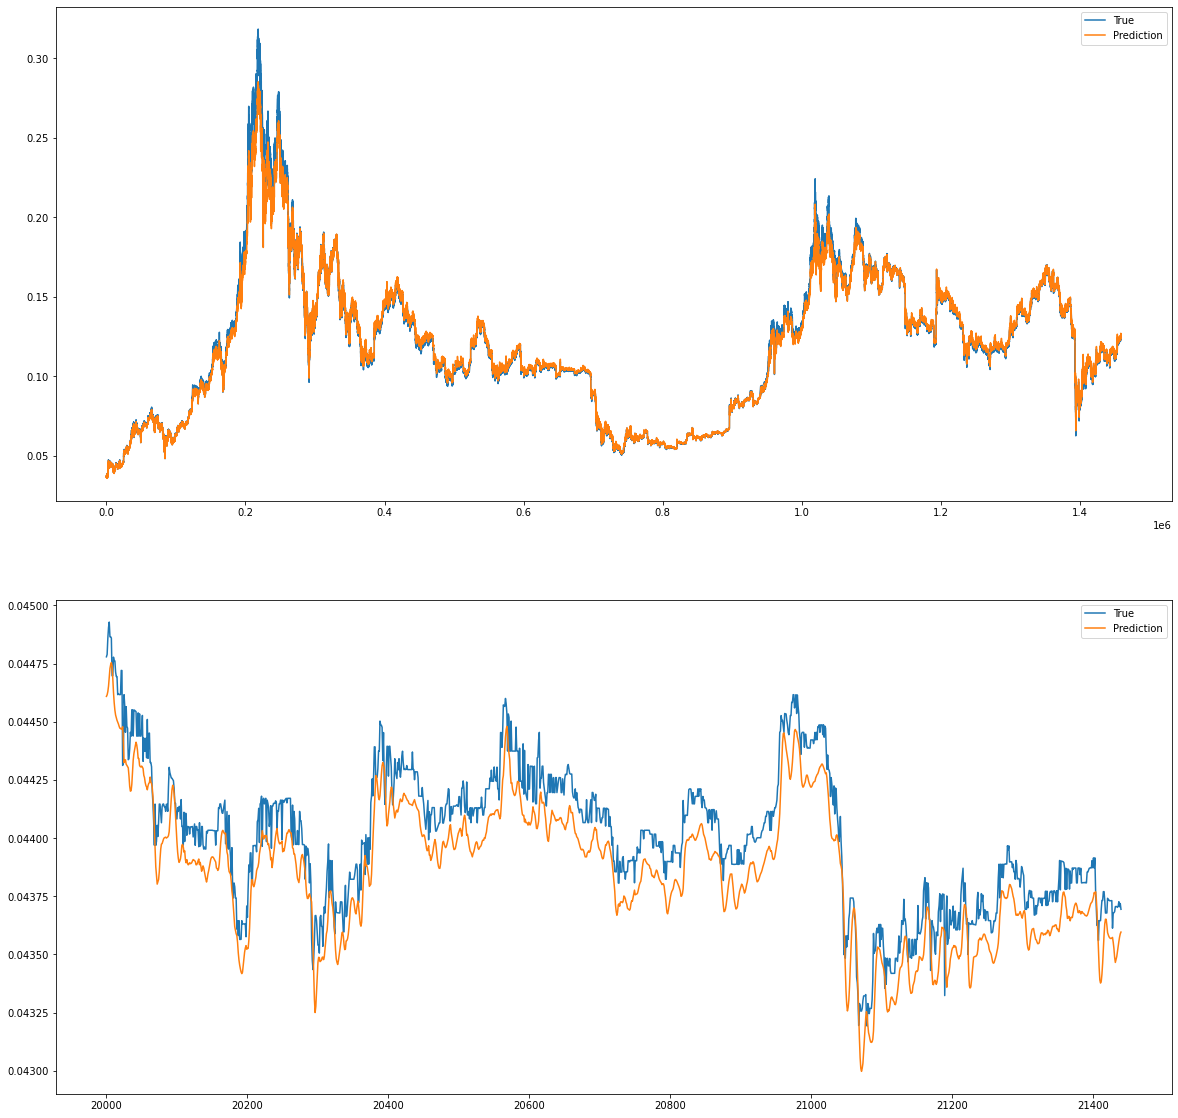

In [17]:
# 학습이 잘 이루어졌는지 예측
pred_val = model_lstm.predict(X_val)
x_range = range(20000, 21440) # 24시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(211)
ax1.plot(y_val, label='True')
ax1.plot(pred_val, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(x_range, y_val[x_range], label='True')
ax2.plot(x_range, pred_val[x_range], label='Prediction')
ax2.legend()

plt.savefig('img/LSTM_train_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

#### 예측 결과 시각화

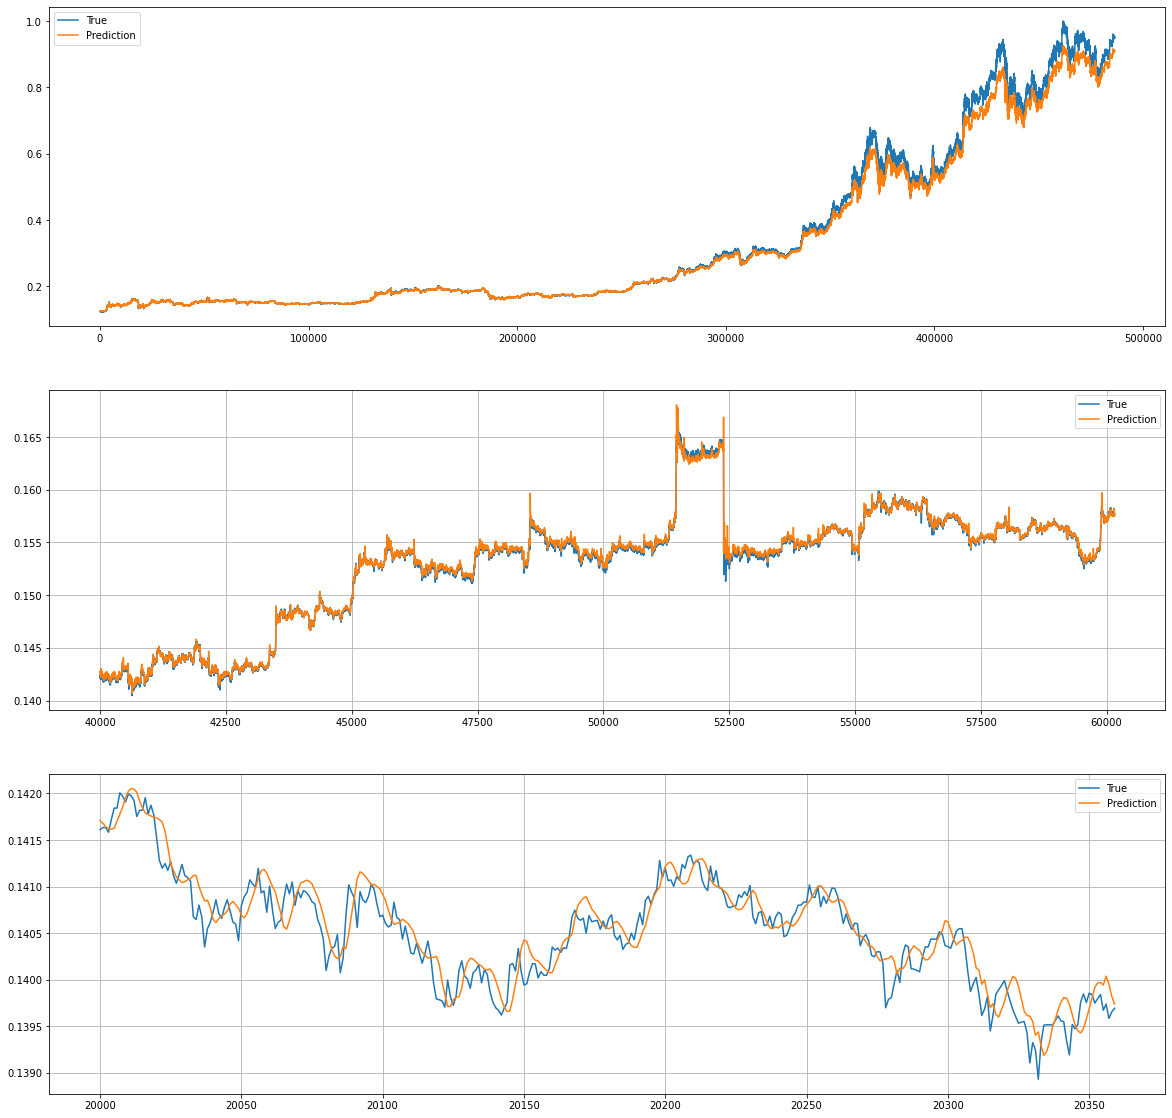

In [18]:
# test case로 예측
pred = model_lstm.predict(X_test)

x_range1 = range(40000, 60160)  # 2주일
x_range2 = range(20000, 20360)  # 6시간

fig = plt.figure(facecolor='white', figsize=(20, 20))
ax1 = fig.add_subplot(311)
ax1.plot(y_test, label='True')
ax1.plot(pred, label='Prediction')
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.plot(x_range1, y_test[x_range1], label='True')
ax2.plot(x_range1, pred[x_range1], label='Prediction')
ax2.legend()
ax2.grid()

ax3 = fig.add_subplot(313)
ax3.plot(x_range2, y_test[x_range2], label='True')
ax3.plot(x_range2, pred[x_range2], label='Prediction')
ax3.legend()
ax3.grid()

plt.savefig('img/LSTM_d{}_v{}.png'.format(DATA_VERSION, MODEL_VERSION))
plt.show()

# 최종 평가

In [20]:
import tensorflow as tf
MODEL_VERSION_EVAL = 1

In [21]:
model_dnn = tf.keras.models.load_model('models/BTC_DNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION_EVAL))
model_cnn = tf.keras.models.load_model('models/BTC_CNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION_EVAL))
model_rnn = tf.keras.models.load_model('models/BTC_RNN_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION_EVAL))
model_lstm = tf.keras.models.load_model('models/BTC_LSTM_d{}_v{}.h5'.format(DATA_VERSION, MODEL_VERSION_EVAL))

In [22]:
dnn_val_mse, dnn_val_mae, dnn_val_mape = model_dnn.evaluate(X_test_dnn, y_test_dnn, verbose=0)
cnn_val_mse, cnn_val_mae, cnn_val_mape = model_cnn.evaluate(X_test, y_test, verbose=0)
rnn_val_mse, rnn_val_mae, rnn_val_mape = model_rnn.evaluate(X_test, y_test, verbose=0)
lstm_val_mse, lstm_val_mae, lstm_val_mape = model_lstm.evaluate(X_test, y_test, verbose=0)

In [26]:
models_evaluation = {}
metrics_name = ['MSE', 'MAE', 'MAPE']
models_evaluation['DNN'] = (dnn_val_mse, dnn_val_mae, dnn_val_mape)
models_evaluation['CNN'] = (cnn_val_mse, cnn_val_mae, cnn_val_mape)
models_evaluation['RNN'] = (rnn_val_mse, rnn_val_mae, rnn_val_mape)
models_evaluation['LSTM'] = (lstm_val_mse, lstm_val_mae, lstm_val_mape)

In [34]:
result = pd.DataFrame(models_evaluation, index=metrics_name)
result = result.T
result

,MSE,MAE,MAPE
DNN,0.108860,0.251894,68.719093
CNN,0.000160,0.007761,1.609632
RNN,0.000855,0.019870,4.598385
LSTM,0.000484,0.011916,1.921549
